## Baseline implementation:

The first step for my homework is to implement baselines. Below, you can find the code for the 3 Baseline that i implement in my work.

In [ ]:
import random
import json
from collections import Counter

# Load data from JSONL file
def load_data(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return data

# Define the Random baseline
class RandomBaseline:
    def __init__(self, possible_labels):
        self.possible_labels = possible_labels

    def fit(self, labels):
        pass

    def predict(self, num_samples):
        return [random.choice(list(self.possible_labels)) for _ in range(num_samples)]

# Define the Stratified baseline
class StratifiedBaseline:
    def __init__(self):
        self.label_distribution = None

    def fit(self, labels):
        # Calculate label distribution in the training set
        self.label_distribution = Counter(labels)

    def predict(self, num_samples):
        # Predict labels following the label distribution in the training set
        predicted_labels = []
        for label, count in self.label_distribution.items():
            predicted_labels.extend([label] * int(num_samples * count / sum(self.label_distribution.values())))
        return predicted_labels

# Define the Majority Class baseline
class MajorityClassBaseline:
    def __init__(self):
        self.most_frequent_class = None

    def fit(self, labels):
        # Count occurrences of each class
        class_counts = Counter(labels)
        # Find the most frequent class
        self.most_frequent_class = class_counts.most_common(1)[0][0]

    def predict(self, num_samples):
        # Return the most frequent class for each sample
        return [self.most_frequent_class] * num_samples

# Compute accuracy
def compute_accuracy(predictions, labels):
    correct_predictions = sum(p == l for p, l in zip(predictions, labels))
    total_samples = len(labels)
    accuracy = correct_predictions / total_samples
    return accuracy

# Load data
train_data = load_data("/content/GxG-task1-train-data.jsonl")
test_data = load_data("/content/GxG-task1-test-data.jsonl")

# Prepare data
train_labels = [example['label'] for example in train_data]
test_labels = [example['label'] for example in test_data]

# Print the number of classes
num_classes = len(set(train_labels))
print("Number of classes:", num_classes)

# Initialize and train the Majority Class baseline
majority_class_baseline = MajorityClassBaseline()
majority_class_baseline.fit(train_labels)

# Predict on test data
predicted_labels = majority_class_baseline.predict(len(test_labels))

# Compute accuracy
accuracy = compute_accuracy(predicted_labels, test_labels)
print("Accuracy of Majority Class baseline:", accuracy)

# Initialize and train the Random baseline
random_baseline = RandomBaseline(possible_labels=set(train_labels))
random_baseline.fit(train_labels)

# Predict on test data
predicted_labels_random = random_baseline.predict(len(test_labels))

# Compute accuracy
accuracy_random = compute_accuracy(predicted_labels_random, test_labels)
print("Accuracy of Random baseline:", accuracy_random)

# Initialize and train the Stratified baseline
stratified_baseline = StratifiedBaseline()
stratified_baseline.fit(train_labels)

# Predict on test data
predicted_labels_stratified = stratified_baseline.predict(len(test_labels))

# Compute accuracy
accuracy_stratified = compute_accuracy(predicted_labels_stratified, test_labels)
print("Accuracy of Stratified baseline:", accuracy_stratified)

Number of classes: 2
Accuracy of Majority Class baseline: 0.5
Accuracy of Random baseline: 0.5034945742137208
Accuracy of Stratified baseline: 0.5021151370240942


Above, we can find the results of the three implemented baselines. The first one is the Majority Class baseline, which always predicts the most frequent class in the training set. The second one implemented is the Random baseline, which, as the name suggests, selects a label uniformly at random among the possible labels. The last one implemented is the Stratified baseline, which predicts the classes following the distribution of labels in the training set.

From the first one, returning 50% ensures that the dataset is balanced. In particular, I also printed the number of classes above which it is 2. Consequently, this further confirms that the dataset is balanced since we have a 50% split with 2 classes.

## LSTM model:

In [ ]:
!python -m spacy download it_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 33.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import json
from pathlib import Path
import torch
from torch.utils.data import Dataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab, vocab
from torch.nn.utils.rnn import pad_sequence
from collections import Counter

class Gxg(Dataset):
    def __init__(
        self,
        input_file: Path,
        max_length: int = 1028,
        device: str = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ):
        tokenizer = get_tokenizer("spacy", language="it_core_news_sm")
        self.samples = []
        with open(input_file, "r", encoding="utf-8") as f:
            for line in f:
                sample = json.loads(line.strip())
                sample["tokens"] = tokenizer(sample["text"])
                self.samples.append(sample)

        self.indexed_data: list[dict] | None = None
        self.max_length = max_length
        self.device = torch.device(device)
        self.padding_id: int | None = None

    def get_raw_element(self, idx: int) -> dict:
        return self.samples[idx]

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx: int) -> dict:
        if self.indexed_data is None:
            raise RuntimeError(
                "Trying to retrieve samples but dataset has not been indexed yet!"
                + " Be sure to call `.index()` on this object."
                + " If you want to retrieve raw elements, call `.get_raw_elements(idx)"
            )
        return self.indexed_data[idx]

    def get_vocabulary(
        self,
        pad_token: str = "<pad>",
        unk_token: str = "<unk>",
        extra_tokens: list[str] = []
    ) -> Vocab:
        all_tokens = [token for sample in self.samples for token in sample["tokens"]]
        vocab_counter = dict(Counter(all_tokens).most_common())
        vocabulary = vocab(vocab_counter, min_freq=1, specials=[pad_token, unk_token, *extra_tokens])
        vocabulary.set_default_index(vocabulary[unk_token])
        return vocabulary

    def set_padding_id(self, value: int) -> None:
        self.padding_id = value

    def index(self, vocabulary: Vocab) -> None:
        if self.indexed_data is not None:
            print("Dataset has already been indexed. Keeping old index...")
        else:
            indexed_data = []
            for sample in self.samples:
                input_ids = [vocabulary[token] for token in sample["tokens"]]
                indexed_data.append({"input_ids": input_ids, "label": sample["label"]})
            self.indexed_data = indexed_data

    def _collate_fn(self, raw_batch: list[dict]) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        if self.padding_id is None:
            raise RuntimeError("Padding value not set! Set it through .set_padding_id method.")

        filtered_batch = [sample for sample in raw_batch if len(sample["input_ids"]) > 0]
        sequence_lengths = torch.tensor([len(sample["input_ids"]) for sample in filtered_batch], dtype=torch.long)
        padded_sequence = pad_sequence(
            (
                torch.tensor(sample["input_ids"], dtype=torch.long, device=self.device)
                for sample in filtered_batch
            ),
            batch_first=True,
            padding_value=self.padding_id
        )
        labels = torch.tensor([sample["label"] for sample in filtered_batch], device=self.device, dtype=torch.long)
        return sequence_lengths, padded_sequence, labels

The code above first initializes the data, then loads the data from the file, tokenizes the data using a tokenizer for Italian sentences (since my dataset consists of Italian sentences). The vocabulary counts the frequency of each token in the sentences.


In [ ]:
!pip install jsonlines

In this code below, I simply printed out the class distribution for informational purposes.

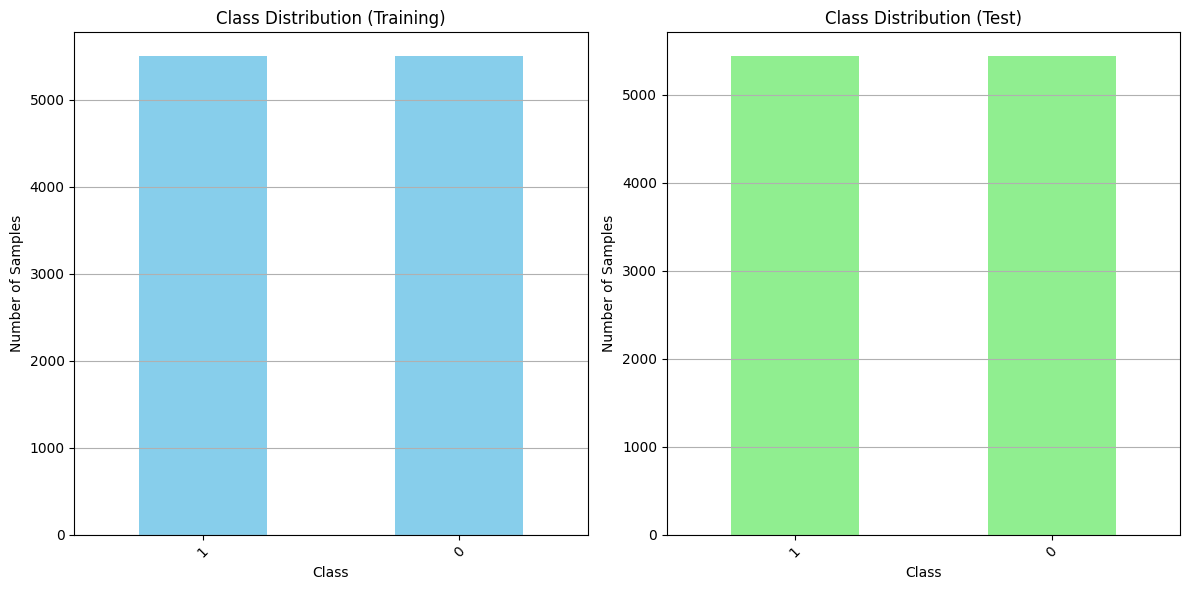

Sample Count per Class (Training):
label
1    5500
0    5500
Name: count, dtype: int64

Sample Count per Class (Test):
label
1    5437
0    5437
Name: count, dtype: int64


In [ ]:
import jsonlines
import pandas as pd
import matplotlib.pyplot as plt

# Function to load data from a JSONL file into a DataFrame
def load_data(file_path):
    data = []
    with jsonlines.open(file_path) as reader:
        for line in reader:
            data.append(line)
    return pd.DataFrame(data)

train_data_path = "/content/GxG-task1-train-data.jsonl"
test_data_path = "/content/GxG-task1-test-data.jsonl"

# Load training and test data
train_df = load_data(train_data_path)
test_df = load_data(test_data_path)

# Count samples per class in training and test data
train_class_counts = train_df['label'].value_counts()
test_class_counts = test_df['label'].value_counts()

# Display class distribution in training data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
train_class_counts.plot(kind='bar', color='skyblue')
plt.title('Class Distribution (Training)')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Display class distribution in test data
plt.subplot(1, 2, 2)
test_class_counts.plot(kind='bar', color='lightgreen')
plt.title('Class Distribution (Test)')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.tight_layout()
plt.show()

# Print sample count for each class in training and test data
print("Sample Count per Class (Training):")
print(train_class_counts)
print("\nSample Count per Class (Test):")
print(test_class_counts)


Below we find the implementation of the LSTM model and the trainer.

In [ ]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence

class LSTMModel(torch.nn.Module):

    def __init__(
        self,
        vocabulary_length: int,
        hidden_dim: int,
        bilstm_layers: int,
        bilstm_dropout: float,
        num_classes: int,
        padding_id: int,
        device: str = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        dropout: float = 0.5,
        batch_norm: bool = False,
        weight_decay: float = 0.0,
        learning_rate: float = 1e-3,
    ) -> None:
        super().__init__()

        # Prepare the device
        self.device = torch.device(device)

        # Embedding layer
        self.embedding = nn.Embedding(
            num_embeddings=vocabulary_length,
            embedding_dim=hidden_dim,
            padding_idx=padding_id, # avoid updating the gradient of padding entries
            device=self.device
        )

        # LSTM
        self.bilstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=bilstm_layers,
            batch_first=True,
            dropout=bilstm_dropout,
            bidirectional=True,
            device=self.device
        )

        # Projection layer
        self.projection = nn.Linear(
            in_features=hidden_dim * 2,
            out_features=num_classes,
            device=device
        )

        # Fully connected layers
        self.fc1 = nn.Linear(
            in_features=hidden_dim * 2,
            out_features=hidden_dim,
            device=device
        )

        self.fc2 = nn.Linear(
            in_features=hidden_dim,
            out_features=num_classes,
            device=device
        )

        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout)

        # Batch normalization layer for improving generalization
        self.batch_norm = nn.BatchNorm1d(hidden_dim * 2) if batch_norm else None

        # Weight decay for L2 regularization
        self.weight_decay = weight_decay

        # Learning rate for optimization
        self.learning_rate = learning_rate

    def forward(self, batch: tuple[torch.Tensor, torch.Tensor]) -> torch.Tensor:
        # Get the different parts of the batch
        sequence_lengths, input_ids = batch

        # First we embed the input tokens
        embeds = self.embedding(input_ids) # [B, S, H]
        # where B is the batch size, S is the sequence length and H is the hidden dimension

        packed = pack_padded_sequence(embeds, sequence_lengths, batch_first=True, enforce_sorted=False)

        packed_output, (hidden_state, cell_state) = self.bilstm(packed)

        hidden = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim = 1)

        # Apply dropout for regularization
        hidden = self.dropout(hidden)

        # Apply batch normalization for improving generalization
        if self.batch_norm is not None:
            hidden = self.batch_norm(hidden)

        # Apply fully connected layers
        hidden = torch.relu(self.fc1(hidden))
        hidden = self.dropout(hidden)
        logits = self.fc2(hidden)

        return logits

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        return optimizer

In [ ]:
from sklearn.metrics import f1_score, accuracy_score
from torch.utils.data import DataLoader

class Trainer():
    def __init__(
        self,
        model: nn.Module,
        optimizer: torch.optim.Optimizer,
        log_steps: int = 1_000,
        log_level: int = 2
    ):
        self.model = model
        self.optimizer = optimizer
        self.loss_function = nn.CrossEntropyLoss()

        self.log_steps = log_steps
        self.log_level = log_level

    def train(
        self,
        train_dataloader: DataLoader,
        valid_dataloader: DataLoader,
        epochs: int = 1
    ) -> dict[str, list[float]]:
        losses = {"train_losses": [], "valid_losses": [], "valid_acc": [], "valid_f1": []}

        for epoch in range(1, epochs + 1):
            if self.log_level > 0:
                print(f"Epoch {epoch}")

            train_loss = 0.0
            self.model.train()

            for step, (sequence_lengths, inputs, labels) in enumerate(train_dataloader):
                self.optimizer.zero_grad()
                predictions = self.model((sequence_lengths, inputs))
                sample_loss = self.loss_function(predictions, labels)
                sample_loss.backward()
                self.optimizer.step()
                train_loss += sample_loss.item()

                if self.log_level > 1 and (step % self.log_steps) == (self.log_steps - 1):
                    print(f"\t[E: {epoch} @ step {step}] current avg loss = {train_loss / (step + 1):.4f}")

            avg_train_loss = train_loss / len(train_dataloader)

            if self.log_level > 0:
                print(f"\t[E: {epoch}] train loss = {avg_train_loss:.4f}")

            valid_loss, valid_acc, valid_f1 = self.evaluate(valid_dataloader)

            losses["train_losses"].append(avg_train_loss)
            losses["valid_losses"].append(valid_loss)
            losses["valid_acc"].append(valid_acc)
            losses["valid_f1"].append(valid_f1)

            if self.log_level > 0:
                print(f"\t[E: {epoch}] valid loss = {valid_loss:.4f}, valid acc = {valid_acc:.4f}, valid f1 = {valid_f1:.4f}")

        return losses

    def evaluate(self, dataloader: DataLoader) -> tuple[float, float, float]:
        self.model.eval()
        total_loss = 0.0
        total_correct = 0
        all_labels = []
        all_predictions = []

        with torch.no_grad():
            for sequence_lengths, inputs, labels in dataloader:
                predictions = self.model((sequence_lengths, inputs))
                loss = self.loss_function(predictions, labels)
                total_loss += loss.item()

                _, predicted_classes = torch.max(predictions, 1)
                total_correct += (predicted_classes == labels).sum().item()

                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted_classes.cpu().numpy())

        avg_loss = total_loss / len(dataloader)
        accuracy = total_correct / len(dataloader.dataset)
        f1 = f1_score(all_labels, all_predictions)

        return avg_loss, accuracy, f1

    def predict(self, dataloader: DataLoader) -> tuple[list[int], list[int]]:
        """
        Effettua previsioni sui dati di un dataloader.

        Args:
            dataloader: DataLoader contenente i dati da prevedere.

        Returns:
            Una tupla contenente:
            - Una lista di etichette reali
            - Una lista di previsioni effettuate dal modello
        """
        self.model.eval()
        all_labels = []
        all_predictions = []

        with torch.no_grad():
            for sequence_lengths, inputs, labels in dataloader:
                predictions = self.model((sequence_lengths, inputs))
                _, predicted_classes = torch.max(predictions, 1)

                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted_classes.cpu().numpy())

        return all_labels, all_predictions

In this section of code, we finally find the loading of data, dataset preparation, and training. At the end, there are also some graphs that show the overall training progress.

In [ ]:
import matplotlib.pyplot as plt
import warnings
from torch.utils.data import random_split, DataLoader
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Suppress warnings
warnings.filterwarnings('ignore')

pad_token, unk_token = "<pad>", "<unk>"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data loading
train_data_path = "/content/GxG-task1-train-data.jsonl"
test_data_path = "/content/GxG-task1-test-data.jsonl"

# Data loading
# Load the data and create dataloaders
train_dataset = Gxg(train_data_path, device=device)
test_dataset = Gxg(test_data_path, device=device)

# Assuming train_dataset has already been created
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, validation_dataset = random_split(train_dataset, [train_size, val_size])

vocabulary = train_dataset.dataset.get_vocabulary(pad_token=pad_token, unk_token=unk_token)
padding_id = vocabulary[pad_token]

train_dataset.dataset.set_padding_id(padding_id)
validation_dataset.dataset.set_padding_id(padding_id)
test_dataset.set_padding_id(padding_id)

train_dataset.dataset.index(vocabulary)
validation_dataset.dataset.index(vocabulary)
test_dataset.index(vocabulary)

print(f"Training len: {len(train_dataset)}")
print(f"Validation len: {len(validation_dataset)}")
print(f"Test len: {len(test_dataset)}")

train_dataloader = DataLoader(train_dataset.dataset, batch_size=32, shuffle=True, collate_fn=train_dataset.dataset._collate_fn)
validation_dataloader = DataLoader(validation_dataset.dataset, batch_size=32, shuffle=False, collate_fn=validation_dataset.dataset._collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=test_dataset._collate_fn)

# Model and optimizer setup
sentiment_tagger = LSTMModel(
    vocabulary_length=len(vocabulary),
    hidden_dim=64,
    bilstm_layers=2,
    bilstm_dropout=0.3,
    num_classes=2,
    padding_id=padding_id,
    device=device,
    dropout=0.2867030271504657,
    batch_norm=True
)

sentiment_tagger.to(device)

optimizer = torch.optim.Adam(sentiment_tagger.parameters(), lr=1.459985138445298e-05)
trainer = Trainer(model=sentiment_tagger, optimizer=optimizer, log_steps=50)

# Model training
losses = trainer.train(train_dataloader, validation_dataloader, epochs=20)

Dataset has already been indexed. Keeping old index...
Training len: 9900
Validation len: 1100
Test len: 10874
Epoch 1
	[E: 1 @ step 49] current avg loss = 0.7159
	[E: 1 @ step 99] current avg loss = 0.7086
	[E: 1 @ step 149] current avg loss = 0.7105
	[E: 1 @ step 199] current avg loss = 0.7073
	[E: 1 @ step 249] current avg loss = 0.7082
	[E: 1 @ step 299] current avg loss = 0.7084
	[E: 1] train loss = 0.7087
	[E: 1] valid loss = 0.6952, valid acc = 0.5177, valid f1 = 0.5706
Epoch 2
	[E: 2 @ step 49] current avg loss = 0.6998
	[E: 2 @ step 99] current avg loss = 0.7019
	[E: 2 @ step 149] current avg loss = 0.7048
	[E: 2 @ step 199] current avg loss = 0.7061
	[E: 2 @ step 249] current avg loss = 0.7071
	[E: 2 @ step 299] current avg loss = 0.7075
	[E: 2] train loss = 0.7076
	[E: 2] valid loss = 0.6931, valid acc = 0.5237, valid f1 = 0.5679
Epoch 3
	[E: 3 @ step 49] current avg loss = 0.6973
	[E: 3 @ step 99] current avg loss = 0.7011
	[E: 3 @ step 149] current avg loss = 0.7042
	[E: 3

I subsequently decided to use Optuna, which is a Python library for automatic and distributed parameter optimization, primarily designed for tuning hyperparameters of machine learning models. It employs search algorithms such as Tree-structured Parzen Estimator (TPE) and Successive Halving to find the best combination of model parameters, minimizing the user-defined objective function.

In [ ]:
!pip install optuna

Below, I carried out a simple hypertuning of 2 hyperparameters to find the best ones for my model and use them subsequently.

In [ ]:
import optuna

def objective(trial):
    # Sampling the hyperparameters
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    dropout = trial.suggest_uniform('dropout', 0.1, 0.5)

    # Model initialization with sampled hyperparameters
    sentiment_tagger = LSTMModel(
        vocabulary_length=len(vocabulary),
        hidden_dim=64,
        bilstm_layers=2,
        bilstm_dropout=0.3,
        num_classes=2,
        padding_id=padding_id,
        device=device,
        dropout=dropout,  # Dropout
        batch_norm=True  # Batch Normalization
    )

    sentiment_tagger.to(device)

    # Optimizer initialization with sampled learning rate
    optimizer = torch.optim.Adam(sentiment_tagger.parameters(), lr=lr)

    # Trainer initialization
    trainer = Trainer(
        model=sentiment_tagger,
        optimizer=optimizer,
        log_steps=100
    )

    # Training
    losses = trainer.train(train_dataloader, validation_dataloader, epochs=10)

    # Returning the validation accuracy as the objective value to be optimized
    return -max(losses["valid_acc"])

# Setting up Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

# Fetching the best hyperparameters
best_lr = study.best_params['lr']
best_dropout = study.best_params['dropout']

# Printing the best hyperparameters found
print("Best hyperparameters:")
print(f"Learning rate: {best_lr}")
print(f"Dropout: {best_dropout}")

[I 2024-04-30 11:42:14,154] A new study created in memory with name: no-name-d2631b56-08bb-471f-baeb-e3632c70ca86


Epoch 1
	[E: 1 @ step 99] current avg loss = 0.7021
	[E: 1 @ step 199] current avg loss = 0.6911
	[E: 1 @ step 299] current avg loss = 0.6855
	[E: 1] train loss = 0.6837
	[E: 1] valid loss = 0.6462, valid acc = 0.6304, valid f1 = 0.5733
Epoch 2
	[E: 2 @ step 99] current avg loss = 0.6337
	[E: 2 @ step 199] current avg loss = 0.6149
	[E: 2 @ step 299] current avg loss = 0.6005
	[E: 2] train loss = 0.5966
	[E: 2] valid loss = 0.4574, valid acc = 0.7904, valid f1 = 0.7900
Epoch 3
	[E: 3 @ step 99] current avg loss = 0.4453
	[E: 3 @ step 199] current avg loss = 0.4502
	[E: 3 @ step 299] current avg loss = 0.4514
	[E: 3] train loss = 0.4562
	[E: 3] valid loss = 0.3024, valid acc = 0.9066, valid f1 = 0.9071
Epoch 4
	[E: 4 @ step 99] current avg loss = 0.2548
	[E: 4 @ step 199] current avg loss = 0.2599
	[E: 4 @ step 299] current avg loss = 0.2615
	[E: 4] train loss = 0.2666
	[E: 4] valid loss = 0.1377, valid acc = 0.9594, valid f1 = 0.9597
Epoch 5
	[E: 5 @ step 99] current avg loss = 0.1430


[I 2024-04-30 11:46:40,796] Trial 0 finished with value: -0.9902727272727273 and parameters: {'lr': 0.0046555989575912966, 'dropout': 0.24683801018302598}. Best is trial 0 with value: -0.9902727272727273.


	[E: 10] valid loss = 0.0239, valid acc = 0.9903, valid f1 = 0.9907
Epoch 1
	[E: 1 @ step 99] current avg loss = 0.7136
	[E: 1 @ step 199] current avg loss = 0.7049
	[E: 1 @ step 299] current avg loss = 0.7000
	[E: 1] train loss = 0.6979
	[E: 1] valid loss = 0.6389, valid acc = 0.6426, valid f1 = 0.7160
Epoch 2
	[E: 2 @ step 99] current avg loss = 0.6526
	[E: 2 @ step 199] current avg loss = 0.6445
	[E: 2 @ step 299] current avg loss = 0.6339
	[E: 2] train loss = 0.6323
	[E: 2] valid loss = 0.5616, valid acc = 0.7374, valid f1 = 0.7648
Epoch 3
	[E: 3 @ step 99] current avg loss = 0.5244
	[E: 3 @ step 199] current avg loss = 0.5214
	[E: 3 @ step 299] current avg loss = 0.5146
	[E: 3] train loss = 0.5110
	[E: 3] valid loss = 0.3662, valid acc = 0.8769, valid f1 = 0.8818
Epoch 4
	[E: 4 @ step 99] current avg loss = 0.3456
	[E: 4 @ step 199] current avg loss = 0.3523
	[E: 4 @ step 299] current avg loss = 0.3513
	[E: 4] train loss = 0.3496
	[E: 4] valid loss = 0.1797, valid acc = 0.9370, va

[I 2024-04-30 11:50:51,669] Trial 1 finished with value: -0.984 and parameters: {'lr': 0.009534557558296554, 'dropout': 0.2823158928209776}. Best is trial 1 with value: -0.984.


	[E: 10] valid loss = 0.0355, valid acc = 0.9840, valid f1 = 0.9843
Epoch 1
	[E: 1 @ step 99] current avg loss = 0.6998
	[E: 1 @ step 199] current avg loss = 0.6943
	[E: 1 @ step 299] current avg loss = 0.6870
	[E: 1] train loss = 0.6836
	[E: 1] valid loss = 0.6020, valid acc = 0.6781, valid f1 = 0.5998
Epoch 2
	[E: 2 @ step 99] current avg loss = 0.5968
	[E: 2 @ step 199] current avg loss = 0.5860
	[E: 2 @ step 299] current avg loss = 0.5784
	[E: 2] train loss = 0.5758
	[E: 2] valid loss = 0.4393, valid acc = 0.7805, valid f1 = 0.8115
Epoch 3
	[E: 3 @ step 99] current avg loss = 0.3945
	[E: 3 @ step 199] current avg loss = 0.3982
	[E: 3 @ step 299] current avg loss = 0.4111
	[E: 3] train loss = 0.4101
	[E: 3] valid loss = 0.1977, valid acc = 0.9272, valid f1 = 0.9268
Epoch 4
	[E: 4 @ step 99] current avg loss = 0.2279
	[E: 4 @ step 199] current avg loss = 0.2301
	[E: 4 @ step 299] current avg loss = 0.2305
	[E: 4] train loss = 0.2346
	[E: 4] valid loss = 0.1070, valid acc = 0.9652, va

[I 2024-04-30 11:55:02,321] Trial 2 finished with value: -0.9913636363636363 and parameters: {'lr': 0.004283404689897967, 'dropout': 0.32670127507995894}. Best is trial 1 with value: -0.984.


	[E: 10] valid loss = 0.0225, valid acc = 0.9914, valid f1 = 0.9918
Epoch 1
	[E: 1 @ step 99] current avg loss = 0.6986
	[E: 1 @ step 199] current avg loss = 0.6949
	[E: 1 @ step 299] current avg loss = 0.6916
	[E: 1] train loss = 0.6906
	[E: 1] valid loss = 0.6475, valid acc = 0.6329, valid f1 = 0.6459
Epoch 2
	[E: 2 @ step 99] current avg loss = 0.6366
	[E: 2 @ step 199] current avg loss = 0.6415
	[E: 2 @ step 299] current avg loss = 0.6389
	[E: 2] train loss = 0.6378
	[E: 2] valid loss = 0.5759, valid acc = 0.7047, valid f1 = 0.7230
Epoch 3
	[E: 3 @ step 99] current avg loss = 0.5732
	[E: 3 @ step 199] current avg loss = 0.5708
	[E: 3 @ step 299] current avg loss = 0.5693
	[E: 3] train loss = 0.5670
	[E: 3] valid loss = 0.4722, valid acc = 0.7713, valid f1 = 0.7797
Epoch 4
	[E: 4 @ step 99] current avg loss = 0.4884
	[E: 4 @ step 199] current avg loss = 0.4820
	[E: 4 @ step 299] current avg loss = 0.4873
	[E: 4] train loss = 0.4896
	[E: 4] valid loss = 0.3923, valid acc = 0.8350, va

[I 2024-04-30 11:59:12,872] Trial 3 finished with value: -0.9766363636363636 and parameters: {'lr': 0.0006766541119692401, 'dropout': 0.19514709574941536}. Best is trial 3 with value: -0.9766363636363636.


	[E: 10] valid loss = 0.0621, valid acc = 0.9766, valid f1 = 0.9772
Epoch 1
	[E: 1 @ step 99] current avg loss = 0.7024
	[E: 1 @ step 199] current avg loss = 0.6994
	[E: 1 @ step 299] current avg loss = 0.6973
	[E: 1] train loss = 0.6962
	[E: 1] valid loss = 0.6751, valid acc = 0.5867, valid f1 = 0.5801
Epoch 2
	[E: 2 @ step 99] current avg loss = 0.6832
	[E: 2 @ step 199] current avg loss = 0.6814
	[E: 2 @ step 299] current avg loss = 0.6809
	[E: 2] train loss = 0.6798
	[E: 2] valid loss = 0.6495, valid acc = 0.6308, valid f1 = 0.6049
Epoch 3
	[E: 3 @ step 99] current avg loss = 0.6586
	[E: 3 @ step 199] current avg loss = 0.6587
	[E: 3 @ step 299] current avg loss = 0.6540
	[E: 3] train loss = 0.6519
	[E: 3] valid loss = 0.6068, valid acc = 0.6719, valid f1 = 0.6708
Epoch 4
	[E: 4 @ step 99] current avg loss = 0.6145
	[E: 4 @ step 199] current avg loss = 0.6200
	[E: 4 @ step 299] current avg loss = 0.6176
	[E: 4] train loss = 0.6165
	[E: 4] valid loss = 0.5576, valid acc = 0.7101, va

[I 2024-04-30 12:03:29,017] Trial 4 finished with value: -0.9080909090909091 and parameters: {'lr': 0.0003002372386670303, 'dropout': 0.3205645907925111}. Best is trial 4 with value: -0.9080909090909091.


	[E: 10] valid loss = 0.2316, valid acc = 0.9081, valid f1 = 0.9095
Best hyperparameters:
Learning rate: 0.0003002372386670303
Dropout: 0.3205645907925111


I've run the code multiple times, and these are the best hyperparameters I found for my model:

Learning rate: 1.459985138445298e-05

Dropout: 0.2867030271504657

Test loss: 0.6945, Test accuracy: 0.5224, Test F1-score: 0.5142


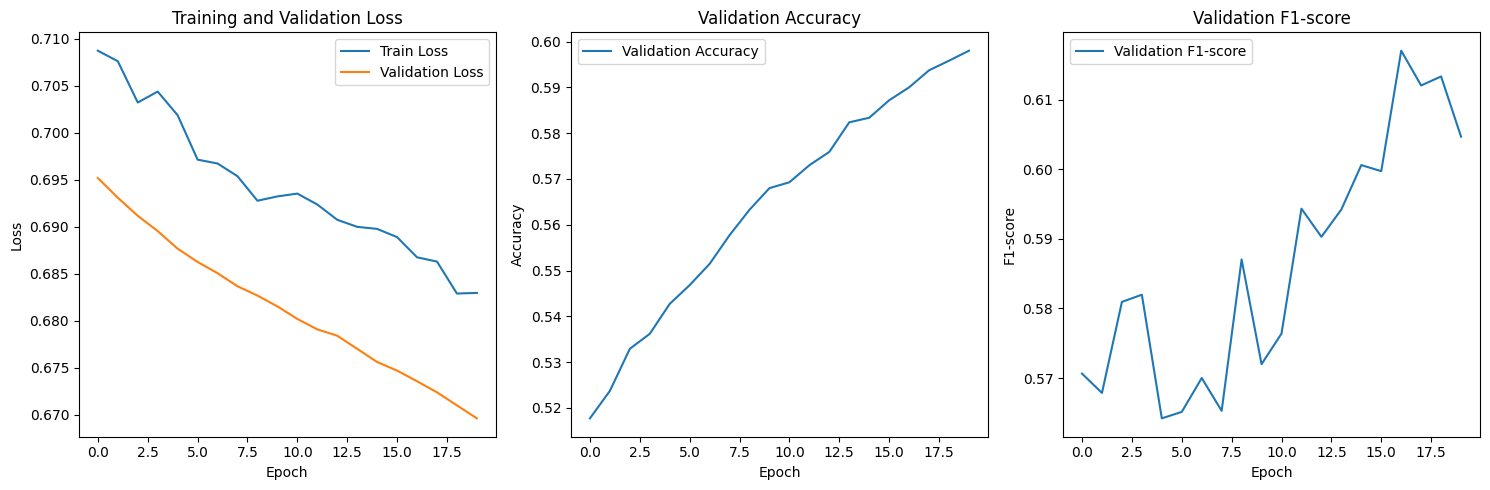

In [ ]:
# Valutazione del modello sui dati di test
test_loss, test_acc, test_f1 = trainer.evaluate(test_dataloader)
test_y_true, test_y_pred = trainer.predict(test_dataloader)
test_f1 = f1_score(test_y_true, test_y_pred)

print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}, Test F1-score: {test_f1:.4f}")

# Visualizzazione dei risultati
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(losses["train_losses"], label="Train Loss")
plt.plot(losses["valid_losses"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(losses["valid_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(losses["valid_f1"], label="Validation F1-score")
plt.xlabel("Epoch")
plt.ylabel("F1-score")
plt.title("Validation F1-score")
plt.legend()

plt.tight_layout()
plt.show()

## CNN model

In this section, I chose to implement a CNN to test the performance of this model on the dataset out of personal curiosity.

In [2]:
import json
from pathlib import Path
from collections import Counter
import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab, vocab
from torch.nn.utils.rnn import pack_padded_sequence
import random

class Gxg(Dataset):
    def __init__(
        self,
        input_file: Path,
        max_length: int = 1028,
        device: str = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ):
        tokenizer = get_tokenizer("basic_english")
        self.samples = []
        with open(input_file, "r") as f:
            for line in f:
                sample = json.loads(line.strip())
                sample["tokens"] = tokenizer(sample["text"])
                self.samples.append(sample)

        self.indexed_data: list[dict] | None = None
        self.max_length = max_length
        self.device = torch.device(device)
        self.padding_id: int | None = None

    def get_raw_element(self, idx: int) -> dict:
        return self.samples[idx]

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx: int) -> dict:
        if self.indexed_data is None:
            raise RuntimeError(
                "Trying to retrieve samples but dataset has not been indexed yet!"
                + " Be sure to call `.index()` on this object."
                + " If you want to retrieve raw elements, call `.get_raw_elements(idx)"
            )
        return self.indexed_data[idx]

    def get_vocabulary(
        self,
        pad_token: str = "<pad>",
        unk_token: str = "<unk>",
        extra_tokens: list[str] = []
    ) -> Vocab:
        all_tokens = [token for sample in self.samples for token in sample["tokens"]]
        vocab_counter = dict(Counter(all_tokens).most_common())
        vocabulary = vocab(vocab_counter, min_freq=1, specials=[pad_token, unk_token, *extra_tokens])
        vocabulary.set_default_index(vocabulary[unk_token])
        return vocabulary

    def set_padding_id(self, value: int) -> None:
        self.padding_id = value

    def index(self, vocabulary: Vocab) -> None:
        if self.indexed_data is not None:
            print("Dataset has already been indexed. Keeping old index...")
        else:
            indexed_data = []
            for sample in self.samples:
                input_ids = [vocabulary[token] for token in sample["tokens"]]
                indexed_data.append({"input_ids": input_ids, "label": sample["label"]})
            self.indexed_data = indexed_data

    def _collate_fn(self, raw_batch: list[dict]) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
      if self.padding_id is None:
          raise RuntimeError("Padding value not set! Set it through .set_padding_id method.")

      filtered_batch = [sample for sample in raw_batch if len(sample["input_ids"]) > 0]
      sequence_lengths = torch.tensor([len(sample["input_ids"]) for sample in filtered_batch], dtype=torch.long)
      padded_sequence = pad_sequence(
          (
              torch.tensor(sample["input_ids"], dtype=torch.long, device=self.device)
              for sample in filtered_batch
          ),
          batch_first=True,
          padding_value=self.padding_id
      )
      labels = torch.tensor([sample["label"] for sample in filtered_batch], device=self.device, dtype=torch.long)
      return padded_sequence, labels

The model I chose to implement in this case is a CNN. In this configuration, the structure is as follows:

  1. The Embedding layer converts word IDs into embedding vectors.

  2. Then, there are convolutional layers that apply convolutional filters of different sizes to the word embedding vectors. The activation function used is ReLU.

  3. After convolution, there is a pooling layer on each convolutional filter to extract the most relevant features.

  4. Finally, there is a fully connected layer that generates the final predictions.

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

class TextCNN(nn.Module):
    def __init__(
        self,
        vocabulary_length: int,
        embedding_dim: int,
        num_filters: int,
        filter_sizes: list[int],
        num_classes: int,
        padding_idx: int,
        dropout_prob: float = 0.5
    ) -> None:
        super(TextCNN, self).__init__()

        self.embedding = nn.Embedding(
            num_embeddings=vocabulary_length,
            embedding_dim=embedding_dim,
            padding_idx=padding_idx
        )

        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=fs)
            for fs in filter_sizes
        ])

        self.fc = nn.Linear(len(filter_sizes) * num_filters, num_classes)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        embedded = self.embedding(x)  # [batch_size, seq_len, embedding_dim]
        embedded = embedded.permute(0, 2, 1)  # [batch_size, embedding_dim, seq_len]

        # Apply convolution and max pooling over each filter size
        conv_outputs = [
            nn.functional.relu(conv(embedded))
            for conv in self.convs
        ]

        pooled_outputs = [
            nn.functional.max_pool1d(conv_output, conv_output.size(2)).squeeze(2)
            for conv_output in conv_outputs
        ]

        # Concatenate pooled features and apply dropout
        cat = torch.cat(pooled_outputs, dim=1)
        cat = self.dropout(cat)

        # Fully connected layer
        logits = self.fc(cat)

        return logits

class Trainer():
    """Utility class to train and evaluate a model."""

    def __init__(
        self,
        model: nn.Module,
        optimizer: torch.optim.Optimizer,
        log_steps: int = 1_000,
        log_level: int = 2
    ):
        self.model = model
        self.optimizer = optimizer
        self.loss_function = nn.CrossEntropyLoss()

        self.log_steps = log_steps
        self.log_level = log_level

    def train(
        self,
        train_dataloader: DataLoader,
        valid_dataloader: DataLoader,
        epochs: int = 1
    ) -> dict[str, list[float]]:
        assert epochs >= 1 and isinstance(epochs, int)
        if self.log_level > 0:
            print('Training ...')
        train_loss = 0.0

        losses = {
            "train_losses": [],
            "valid_losses": [],
            "valid_acc": [],
            "valid_f1": []  # Aggiunta della F1 score nella registrazione delle metriche
        }

        for epoch in range(1, epochs + 1):
            if self.log_level > 0:
                print(' Epoch {:2d}'.format(epoch))

            epoch_loss = 0.0
            self.model.train()

            for step, batch in enumerate(train_dataloader):
                self.optimizer.zero_grad()

                inputs, labels = batch
                predictions = self.model(inputs)

                sample_loss = self.loss_function(predictions, labels)
                sample_loss.backward()
                self.optimizer.step()

                epoch_loss += sample_loss.cpu().tolist()

                if self.log_level > 1 and (step % self.log_steps) == (self.log_steps - 1):
                    print('\t[E: {:2d} @ step {}] current avg loss = {:0.4f}'.format(epoch, step, epoch_loss / (step + 1)))

            avg_epoch_loss = epoch_loss / len(train_dataloader)

            if self.log_level > 0:
                print('\t[E: {:2d}] train loss = {:0.4f}'.format(epoch, avg_epoch_loss))

            valid_loss, valid_acc, valid_f1 = self.evaluate(valid_dataloader)  # Aggiunta della F1 score nella valutazione

            losses["train_losses"].append(avg_epoch_loss)
            losses["valid_losses"].append(valid_loss)
            losses["valid_acc"].append(valid_acc)
            losses["valid_f1"].append(valid_f1)  # Aggiunta della F1 score nella registrazione delle metriche

            if self.log_level > 0:
                print('  [E: {:2d}] valid loss = {:0.4f}, valid acc = {:0.4f}, valid f1 = {:0.4f}'.format(epoch, valid_loss, valid_acc, valid_f1))

        if self.log_level > 0:
            print('... Done!')

        return losses

    def _compute_acc(self, logits: torch.Tensor, labels: torch.Tensor) -> float:
        predictions = torch.argmax(logits, dim=1)
        return torch.mean((predictions == labels).float()).tolist()

    def _compute_f1(self, logits: torch.Tensor, labels: torch.Tensor) -> float:
        predictions = torch.argmax(logits, dim=1)
        true_positives = torch.sum(predictions * labels).float()
        predicted_positives = torch.sum(predictions).float()
        actual_positives = torch.sum(labels).float()

        precision = true_positives / (predicted_positives + 1e-7)
        recall = true_positives / (actual_positives + 1e-7)

        f1 = 2 * (precision * recall) / (precision + recall + 1e-7)
        return f1.item()

    def evaluate(self, valid_dataloader: DataLoader) -> tuple[float, float, float]:
        valid_loss = 0.0
        valid_acc = 0.0
        valid_f1 = 0.0

        self.model.eval()
        with torch.no_grad():
            for batch in valid_dataloader:
                inputs, labels = batch
                logits = self.model(inputs)

                sample_loss = self.loss_function(logits, labels)
                valid_loss += sample_loss.tolist()

                sample_acc = self._compute_acc(logits, labels)
                valid_acc += sample_acc

                sample_f1 = self._compute_f1(logits, labels)  # Calcolo della F1 score
                valid_f1 += sample_f1

        num_batches = len(valid_dataloader)
        return valid_loss / num_batches, valid_acc / num_batches, valid_f1 / num_batches

Dataset has already been indexed. Keeping old index...
Training len: 9900
Validation len: 1100
Test len: 10874
Training ...
 Epoch  1
	[E:  1 @ step 49] current avg loss = 0.7319
	[E:  1 @ step 99] current avg loss = 0.7175
	[E:  1 @ step 149] current avg loss = 0.7107
	[E:  1] train loss = 0.7105
  [E:  1] valid loss = 0.6716, valid acc = 0.5810, valid f1 = 0.6585
 Epoch  2
	[E:  2 @ step 49] current avg loss = 0.6287
	[E:  2 @ step 99] current avg loss = 0.6288
	[E:  2 @ step 149] current avg loss = 0.6302
	[E:  2] train loss = 0.6308
  [E:  2] valid loss = 0.6521, valid acc = 0.6053, valid f1 = 0.6606
 Epoch  3
	[E:  3 @ step 49] current avg loss = 0.5808
	[E:  3 @ step 99] current avg loss = 0.5776
	[E:  3 @ step 149] current avg loss = 0.5739
	[E:  3] train loss = 0.5736
  [E:  3] valid loss = 0.6258, valid acc = 0.6397, valid f1 = 0.6194
 Epoch  4
	[E:  4 @ step 49] current avg loss = 0.5204
	[E:  4 @ step 99] current avg loss = 0.5212
	[E:  4 @ step 149] current avg loss = 0.524

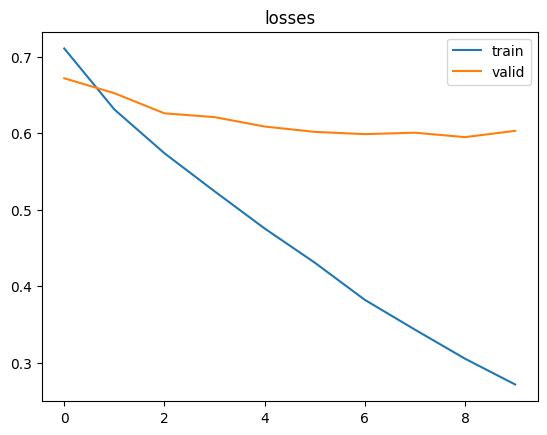

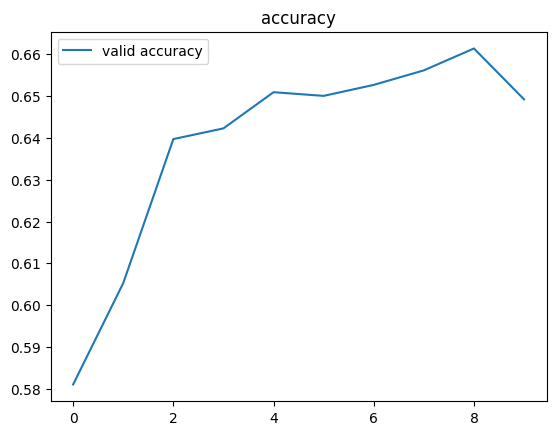

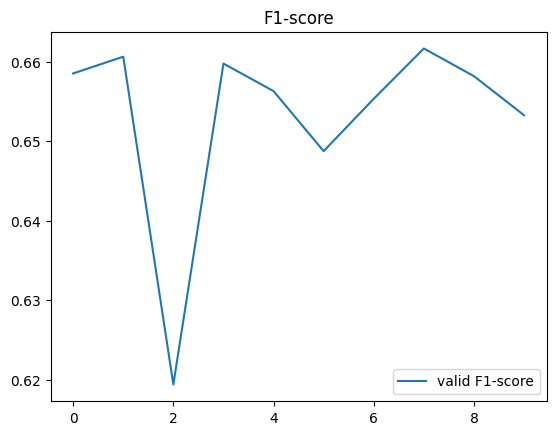

Test loss 0.8216978402698741, Test accuracy: 0.5258113591110005, Test f1_score: 0.42198515214464244


In [5]:
import matplotlib.pyplot as plt
import warnings
from torch.utils.data import random_split, DataLoader

warnings.filterwarnings('ignore')

pad_token, unk_token = "<pad>", "<unk>"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Caricamento dei dati
train_data_path = "/content/GxG-task1-train-data.jsonl"
test_data_path = "/content/GxG-task1-test-data.jsonl"

# Caricamento dei dati
train_dataset = Gxg(train_data_path, device=device)
test_dataset = Gxg(test_data_path, device=device)

# Calcolo delle dimensioni dei set di addestramento e convalida
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size

# Divisione dei dati in set di addestramento e convalida
train_dataset, validation_dataset = random_split(train_dataset, [train_size, val_size])

vocabulary = train_dataset.dataset.get_vocabulary(pad_token=pad_token, unk_token=unk_token)
padding_id = vocabulary([pad_token])[0]

train_dataset.dataset.set_padding_id(padding_id)
validation_dataset.dataset.set_padding_id(padding_id)
test_dataset.set_padding_id(padding_id)

train_dataset.dataset.index(vocabulary)
validation_dataset.dataset.index(vocabulary)
test_dataset.index(vocabulary)

print(f"Training len: {len(train_dataset)}")
print(f"Validation len: {len(validation_dataset)}")
print(f"Test len: {len(test_dataset)}")

training_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=train_dataset.dataset._collate_fn)
validation_dataloader = DataLoader(validation_dataset, batch_size=64, shuffle=False, collate_fn=validation_dataset.dataset._collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=test_dataset._collate_fn)

sentiment_tagger = TextCNN(
    vocabulary_length=len(vocabulary),
    embedding_dim=216,  # specificare la dimensione dell'embedding
    num_filters=116,  # specificare il numero di filtri per ogni dimensione della finestra convoluzionale
    filter_sizes=[5, 6, 3],  # specificare le dimensioni delle finestre convoluzionali
    num_classes=2,
    padding_idx=padding_id,
    dropout_prob=0.20278437171318142  # specificare la probabilità di dropout
)

sentiment_tagger.to(device)

trainer = Trainer(
    model=sentiment_tagger,
    optimizer=torch.optim.Adam(sentiment_tagger.parameters(), lr=0.0001),
    log_steps=50
)

losses = trainer.train(training_dataloader, validation_dataloader, epochs=10)

plt.title("losses")
plt.plot(losses["train_losses"], label="train")
plt.plot(losses["valid_losses"], label="valid")
plt.legend()
plt.show()

plt.title("accuracy")
plt.plot(losses["valid_acc"], label="valid accuracy")
plt.legend()
plt.show()

plt.title("F1-score")
plt.plot(losses["valid_f1"], label="valid F1-score")
plt.legend()
plt.show()

test_loss, test_acc, f1_score = trainer.evaluate(test_dataloader)

print(f"Test loss {test_loss}, Test accuracy: {test_acc}, Test f1_score: {f1_score}")


Here, I simply tuned the hyperparameters using Optuna.

In [ ]:
import optuna

def objective(trial):
    # Define the search space for hyperparameters
    embedding_dim = trial.suggest_int("embedding_dim", 50, 300)
    num_filters = trial.suggest_int("num_filters", 64, 256)
    filter_sizes = [trial.suggest_int(f"filter_size_{i}", 3, 7) for i in range(3)]  # Assuming we want to try 3 different filter sizes
    dropout_prob = trial.suggest_uniform("dropout_prob", 0.2, 0.7)

    # Initialize the model
    model = TextCNN(
        vocabulary_length=len(vocabulary),
        embedding_dim=embedding_dim,
        num_filters=num_filters,
        filter_sizes=filter_sizes,
        num_classes=2,
        padding_idx=padding_id,
        dropout_prob=dropout_prob
    )

    model.to(device)

    # Initialize the trainer
    trainer = Trainer(
        model=model,
        optimizer=torch.optim.Adam(model.parameters(), lr=0.001),
        log_steps=50
    )

    # Train the model
    losses = trainer.train(training_dataloader, validation_dataloader, epochs=15)

    # Get the best validation accuracy achieved during training
    best_valid_acc = max(losses["valid_acc"])

    return best_valid_acc

# Create a study object and optimize the objective function
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)  # You can adjust the number of trials as needed

# Get the best hyperparameters and their values
best_params = study.best_params
best_embedding_dim = best_params["embedding_dim"]
best_num_filters = best_params["num_filters"]
best_filter_sizes = [best_params[f"filter_size_{i}"] for i in range(3)]  # Assuming we tried 3 different filter sizes
best_dropout_prob = best_params["dropout_prob"]

print("Best hyperparameters found:")
print("embedding_dim:", best_embedding_dim)
print("num_filters:", best_num_filters)
print("filter_sizes:", best_filter_sizes)
print("dropout_prob:", best_dropout_prob)

[I 2024-04-30 12:05:01,025] A new study created in memory with name: no-name-60ee88a1-ef4f-40e9-a4f4-09739d080e50


Training ...
 Epoch  1
	[E:  1 @ step 49] current avg loss = 0.7192
	[E:  1 @ step 99] current avg loss = 0.7100
	[E:  1 @ step 149] current avg loss = 0.6927
	[E:  1] train loss = 0.6916
  [E:  1] valid loss = 0.6006, valid acc = 0.6508, valid f1 = 0.6606
 Epoch  2
	[E:  2 @ step 49] current avg loss = 0.5070
	[E:  2 @ step 99] current avg loss = 0.5160
	[E:  2 @ step 149] current avg loss = 0.5213
	[E:  2] train loss = 0.5222
  [E:  2] valid loss = 0.5852, valid acc = 0.6542, valid f1 = 0.6761
 Epoch  3
	[E:  3 @ step 49] current avg loss = 0.3841
	[E:  3 @ step 99] current avg loss = 0.3893
	[E:  3 @ step 149] current avg loss = 0.4016
	[E:  3] train loss = 0.4011
  [E:  3] valid loss = 0.6488, valid acc = 0.6542, valid f1 = 0.5963
 Epoch  4
	[E:  4 @ step 49] current avg loss = 0.2914
	[E:  4 @ step 99] current avg loss = 0.2953
	[E:  4 @ step 149] current avg loss = 0.3087
	[E:  4] train loss = 0.3075
  [E:  4] valid loss = 0.6582, valid acc = 0.6525, valid f1 = 0.6725
 Epoch  5
	

[I 2024-04-30 12:06:36,588] Trial 0 finished with value: 0.6646412048074934 and parameters: {'embedding_dim': 189, 'num_filters': 83, 'filter_size_0': 6, 'filter_size_1': 4, 'filter_size_2': 3, 'dropout_prob': 0.2957789642480348}. Best is trial 0 with value: 0.6646412048074934.


	[E: 15] train loss = 0.0460
  [E: 15] valid loss = 1.2189, valid acc = 0.6539, valid f1 = 0.6228
... Done!
Training ...
 Epoch  1
	[E:  1 @ step 49] current avg loss = 0.8754
	[E:  1 @ step 99] current avg loss = 0.8407
	[E:  1 @ step 149] current avg loss = 0.8019
	[E:  1] train loss = 0.7999
  [E:  1] valid loss = 0.6459, valid acc = 0.6221, valid f1 = 0.6857
 Epoch  2
	[E:  2 @ step 49] current avg loss = 0.6372
	[E:  2 @ step 99] current avg loss = 0.6418
	[E:  2 @ step 149] current avg loss = 0.6382
	[E:  2] train loss = 0.6397
  [E:  2] valid loss = 0.6241, valid acc = 0.6343, valid f1 = 0.6964
 Epoch  3
	[E:  3 @ step 49] current avg loss = 0.5868
	[E:  3 @ step 99] current avg loss = 0.5991
	[E:  3 @ step 149] current avg loss = 0.5945
	[E:  3] train loss = 0.5923
  [E:  3] valid loss = 0.5996, valid acc = 0.6305, valid f1 = 0.5690
 Epoch  4
	[E:  4 @ step 49] current avg loss = 0.5346
	[E:  4 @ step 99] current avg loss = 0.5405
	[E:  4 @ step 149] current avg loss = 0.5451
	

[I 2024-04-30 12:08:31,685] Trial 1 finished with value: 0.6669560207260979 and parameters: {'embedding_dim': 166, 'num_filters': 162, 'filter_size_0': 3, 'filter_size_1': 7, 'filter_size_2': 3, 'dropout_prob': 0.6960360213852388}. Best is trial 1 with value: 0.6669560207260979.


  [E: 15] valid loss = 1.1825, valid acc = 0.6467, valid f1 = 0.6270
... Done!
Training ...
 Epoch  1
	[E:  1 @ step 49] current avg loss = 0.8447
	[E:  1 @ step 99] current avg loss = 0.8036
	[E:  1 @ step 149] current avg loss = 0.7860
	[E:  1] train loss = 0.7833
  [E:  1] valid loss = 0.6337, valid acc = 0.6149, valid f1 = 0.6218
 Epoch  2
	[E:  2 @ step 49] current avg loss = 0.6449
	[E:  2 @ step 99] current avg loss = 0.6538
	[E:  2 @ step 149] current avg loss = 0.6548
	[E:  2] train loss = 0.6539
  [E:  2] valid loss = 0.6085, valid acc = 0.6444, valid f1 = 0.6423
 Epoch  3
	[E:  3 @ step 49] current avg loss = 0.5941
	[E:  3 @ step 99] current avg loss = 0.5855
	[E:  3 @ step 149] current avg loss = 0.5889
	[E:  3] train loss = 0.5892
  [E:  3] valid loss = 0.6026, valid acc = 0.6302, valid f1 = 0.6058
 Epoch  4
	[E:  4 @ step 49] current avg loss = 0.4978
	[E:  4 @ step 99] current avg loss = 0.5163
	[E:  4 @ step 149] current avg loss = 0.5269
	[E:  4] train loss = 0.5264
 

[I 2024-04-30 12:10:48,522] Trial 2 finished with value: 0.6608796318372091 and parameters: {'embedding_dim': 164, 'num_filters': 221, 'filter_size_0': 4, 'filter_size_1': 7, 'filter_size_2': 4, 'dropout_prob': 0.6934872466079189}. Best is trial 1 with value: 0.6669560207260979.


  [E: 15] valid loss = 1.2481, valid acc = 0.6447, valid f1 = 0.6365
... Done!
Training ...
 Epoch  1
	[E:  1 @ step 49] current avg loss = 0.7435
	[E:  1 @ step 99] current avg loss = 0.7136
	[E:  1 @ step 149] current avg loss = 0.7069
	[E:  1] train loss = 0.7050
  [E:  1] valid loss = 0.5956, valid acc = 0.6681, valid f1 = 0.7007
 Epoch  2
	[E:  2 @ step 49] current avg loss = 0.4115
	[E:  2 @ step 99] current avg loss = 0.4245
	[E:  2 @ step 149] current avg loss = 0.4387
	[E:  2] train loss = 0.4384
  [E:  2] valid loss = 0.6229, valid acc = 0.6493, valid f1 = 0.6253
 Epoch  3
	[E:  3 @ step 49] current avg loss = 0.2496
	[E:  3 @ step 99] current avg loss = 0.2433
	[E:  3 @ step 149] current avg loss = 0.2535
	[E:  3] train loss = 0.2550
  [E:  3] valid loss = 0.6626, valid acc = 0.6704, valid f1 = 0.6868
 Epoch  4
	[E:  4 @ step 49] current avg loss = 0.1455
	[E:  4 @ step 99] current avg loss = 0.1529
	[E:  4 @ step 149] current avg loss = 0.1604
	[E:  4] train loss = 0.1614
 

[I 2024-04-30 12:14:01,380] Trial 3 finished with value: 0.6796875 and parameters: {'embedding_dim': 280, 'num_filters': 212, 'filter_size_0': 6, 'filter_size_1': 3, 'filter_size_2': 5, 'dropout_prob': 0.2248270192450404}. Best is trial 3 with value: 0.6796875.


  [E: 15] valid loss = 1.3929, valid acc = 0.6664, valid f1 = 0.6663
... Done!
Training ...
 Epoch  1
	[E:  1 @ step 49] current avg loss = 0.7075
	[E:  1 @ step 99] current avg loss = 0.6999
	[E:  1 @ step 149] current avg loss = 0.6941
	[E:  1] train loss = 0.6922
  [E:  1] valid loss = 0.6463, valid acc = 0.6328, valid f1 = 0.7029
 Epoch  2
	[E:  2 @ step 49] current avg loss = 0.4741
	[E:  2 @ step 99] current avg loss = 0.4774
	[E:  2 @ step 149] current avg loss = 0.4869
	[E:  2] train loss = 0.4869
  [E:  2] valid loss = 0.6067, valid acc = 0.6615, valid f1 = 0.6664
 Epoch  3
	[E:  3 @ step 49] current avg loss = 0.3190
	[E:  3 @ step 99] current avg loss = 0.3299
	[E:  3 @ step 149] current avg loss = 0.3409
	[E:  3] train loss = 0.3422
  [E:  3] valid loss = 0.6657, valid acc = 0.6568, valid f1 = 0.6870
 Epoch  4
	[E:  4 @ step 49] current avg loss = 0.2082
	[E:  4 @ step 99] current avg loss = 0.2187
	[E:  4 @ step 149] current avg loss = 0.2212
	[E:  4] train loss = 0.2219
 

[I 2024-04-30 12:16:02,666] Trial 4 finished with value: 0.6796875 and parameters: {'embedding_dim': 156, 'num_filters': 148, 'filter_size_0': 5, 'filter_size_1': 5, 'filter_size_2': 4, 'dropout_prob': 0.24272597578966626}. Best is trial 3 with value: 0.6796875.


  [E: 15] valid loss = 1.1888, valid acc = 0.6641, valid f1 = 0.6431
... Done!
Training ...
 Epoch  1
	[E:  1 @ step 49] current avg loss = 0.7496
	[E:  1 @ step 99] current avg loss = 0.7243
	[E:  1 @ step 149] current avg loss = 0.7052
	[E:  1] train loss = 0.7035
  [E:  1] valid loss = 0.6405, valid acc = 0.6189, valid f1 = 0.6303
 Epoch  2
	[E:  2 @ step 49] current avg loss = 0.5716
	[E:  2 @ step 99] current avg loss = 0.5701
	[E:  2 @ step 149] current avg loss = 0.5724
	[E:  2] train loss = 0.5745
  [E:  2] valid loss = 0.6154, valid acc = 0.6262, valid f1 = 0.6419
 Epoch  3
	[E:  3 @ step 49] current avg loss = 0.4772
	[E:  3 @ step 99] current avg loss = 0.4852
	[E:  3 @ step 149] current avg loss = 0.4861
	[E:  3] train loss = 0.4873
  [E:  3] valid loss = 0.6101, valid acc = 0.6470, valid f1 = 0.6622
 Epoch  4
	[E:  4 @ step 49] current avg loss = 0.3894
	[E:  4 @ step 99] current avg loss = 0.3958
	[E:  4 @ step 149] current avg loss = 0.4072
	[E:  4] train loss = 0.4093
 

[I 2024-04-30 12:17:15,690] Trial 5 finished with value: 0.6548032429483202 and parameters: {'embedding_dim': 99, 'num_filters': 103, 'filter_size_0': 4, 'filter_size_1': 4, 'filter_size_2': 3, 'dropout_prob': 0.3293890658995543}. Best is trial 3 with value: 0.6796875.


  [E: 15] valid loss = 1.1798, valid acc = 0.6487, valid f1 = 0.6750
... Done!
Training ...
 Epoch  1
	[E:  1 @ step 49] current avg loss = 0.7511
	[E:  1 @ step 99] current avg loss = 0.7359
	[E:  1 @ step 149] current avg loss = 0.7194
	[E:  1] train loss = 0.7202
  [E:  1] valid loss = 0.6292, valid acc = 0.6088, valid f1 = 0.5332
 Epoch  2
	[E:  2 @ step 49] current avg loss = 0.5331
	[E:  2 @ step 99] current avg loss = 0.5348
	[E:  2 @ step 149] current avg loss = 0.5455
	[E:  2] train loss = 0.5463
  [E:  2] valid loss = 0.6628, valid acc = 0.6337, valid f1 = 0.7000
 Epoch  3
	[E:  3 @ step 49] current avg loss = 0.4050
	[E:  3 @ step 99] current avg loss = 0.4086
	[E:  3 @ step 149] current avg loss = 0.4166
	[E:  3] train loss = 0.4173
  [E:  3] valid loss = 0.6302, valid acc = 0.6562, valid f1 = 0.6135
 Epoch  4
	[E:  4 @ step 49] current avg loss = 0.2832
	[E:  4 @ step 99] current avg loss = 0.3075
	[E:  4 @ step 149] current avg loss = 0.3197
	[E:  4] train loss = 0.3219
 

[I 2024-04-30 12:19:14,233] Trial 6 finished with value: 0.6750578714741601 and parameters: {'embedding_dim': 104, 'num_filters': 252, 'filter_size_0': 5, 'filter_size_1': 6, 'filter_size_2': 7, 'dropout_prob': 0.41921586034287595}. Best is trial 3 with value: 0.6796875.


  [E: 15] valid loss = 1.3552, valid acc = 0.6675, valid f1 = 0.7000
... Done!
Training ...
 Epoch  1
	[E:  1 @ step 49] current avg loss = 0.7375
	[E:  1 @ step 99] current avg loss = 0.7134
	[E:  1 @ step 149] current avg loss = 0.7052
	[E:  1] train loss = 0.7048
  [E:  1] valid loss = 0.6362, valid acc = 0.6291, valid f1 = 0.6971
 Epoch  2
	[E:  2 @ step 49] current avg loss = 0.5145
	[E:  2 @ step 99] current avg loss = 0.5224
	[E:  2 @ step 149] current avg loss = 0.5323
	[E:  2] train loss = 0.5337
  [E:  2] valid loss = 0.6041, valid acc = 0.6510, valid f1 = 0.6931
 Epoch  3
	[E:  3 @ step 49] current avg loss = 0.4044
	[E:  3 @ step 99] current avg loss = 0.4084
	[E:  3 @ step 149] current avg loss = 0.4232
	[E:  3] train loss = 0.4248
  [E:  3] valid loss = 0.6377, valid acc = 0.6545, valid f1 = 0.7022
 Epoch  4
	[E:  4 @ step 49] current avg loss = 0.3103
	[E:  4 @ step 99] current avg loss = 0.3139
	[E:  4 @ step 149] current avg loss = 0.3284
	[E:  4] train loss = 0.3289
 

[I 2024-04-30 12:20:56,406] Trial 7 finished with value: 0.6788194444444444 and parameters: {'embedding_dim': 120, 'num_filters': 147, 'filter_size_0': 3, 'filter_size_1': 5, 'filter_size_2': 7, 'dropout_prob': 0.338528707973512}. Best is trial 3 with value: 0.6796875.


  [E: 15] valid loss = 1.0933, valid acc = 0.6759, valid f1 = 0.6403
... Done!
Training ...
 Epoch  1
	[E:  1 @ step 49] current avg loss = 0.7365
	[E:  1 @ step 99] current avg loss = 0.7131
	[E:  1 @ step 149] current avg loss = 0.6926
	[E:  1] train loss = 0.6921
  [E:  1] valid loss = 0.6104, valid acc = 0.6178, valid f1 = 0.5938
 Epoch  2
	[E:  2 @ step 49] current avg loss = 0.4956
	[E:  2 @ step 99] current avg loss = 0.5020
	[E:  2 @ step 149] current avg loss = 0.5103
	[E:  2] train loss = 0.5105
  [E:  2] valid loss = 0.6400, valid acc = 0.6412, valid f1 = 0.7041
 Epoch  3
	[E:  3 @ step 49] current avg loss = 0.3643
	[E:  3 @ step 99] current avg loss = 0.3703
	[E:  3 @ step 149] current avg loss = 0.3833
	[E:  3] train loss = 0.3854
  [E:  3] valid loss = 0.6244, valid acc = 0.6516, valid f1 = 0.6431
 Epoch  4
	[E:  4 @ step 49] current avg loss = 0.2469
	[E:  4 @ step 99] current avg loss = 0.2604
	[E:  4 @ step 149] current avg loss = 0.2695
	[E:  4] train loss = 0.2709
 

[I 2024-04-30 12:23:17,818] Trial 8 finished with value: 0.6730324096149869 and parameters: {'embedding_dim': 298, 'num_filters': 90, 'filter_size_0': 3, 'filter_size_1': 6, 'filter_size_2': 5, 'dropout_prob': 0.33039402159743836}. Best is trial 3 with value: 0.6796875.


  [E: 15] valid loss = 1.2830, valid acc = 0.6455, valid f1 = 0.6167
... Done!
Training ...
 Epoch  1
	[E:  1 @ step 49] current avg loss = 0.7500
	[E:  1 @ step 99] current avg loss = 0.7162
	[E:  1 @ step 149] current avg loss = 0.6985
	[E:  1] train loss = 0.6972
  [E:  1] valid loss = 0.6050, valid acc = 0.6453, valid f1 = 0.6664
 Epoch  2
	[E:  2 @ step 49] current avg loss = 0.5053
	[E:  2 @ step 99] current avg loss = 0.5185
	[E:  2 @ step 149] current avg loss = 0.5320
	[E:  2] train loss = 0.5332
  [E:  2] valid loss = 0.5982, valid acc = 0.6597, valid f1 = 0.6940
 Epoch  3
	[E:  3 @ step 49] current avg loss = 0.3880
	[E:  3 @ step 99] current avg loss = 0.3999
	[E:  3 @ step 149] current avg loss = 0.4146
	[E:  3] train loss = 0.4166
  [E:  3] valid loss = 0.6403, valid acc = 0.6646, valid f1 = 0.7053
 Epoch  4
	[E:  4 @ step 49] current avg loss = 0.2974
	[E:  4 @ step 99] current avg loss = 0.3037
	[E:  4 @ step 149] current avg loss = 0.3187
	[E:  4] train loss = 0.3183
 

[I 2024-04-30 12:25:28,133] Trial 9 finished with value: 0.6895254651705424 and parameters: {'embedding_dim': 249, 'num_filters': 127, 'filter_size_0': 3, 'filter_size_1': 3, 'filter_size_2': 6, 'dropout_prob': 0.39204658292061534}. Best is trial 9 with value: 0.6895254651705424.


  [E: 15] valid loss = 1.2830, valid acc = 0.6646, valid f1 = 0.6270
... Done!
Best hyperparameters found:
embedding_dim: 249
num_filters: 127
filter_sizes: [3, 3, 6]
dropout_prob: 0.39204658292061534


## Word2vec model

In [ ]:
import json
import nltk
import gensim
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# Downloading NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Paths to the train and test data files
train_data_path = "/content/GxG-task1-train-data.jsonl"
test_data_path = "/content/GxG-task1-test-data.jsonl"

# Loading train and test data
train_sentences, train_labels = [], []
with open(train_data_path, 'r') as train_file:
    for line in train_file:
        data = json.loads(line)
        train_sentences.append(data['text'])
        train_labels.append(data['label'])

test_sentences, test_labels = [], []
with open(test_data_path, 'r') as test_file:
    for line in test_file:
        data = json.loads(line)
        test_sentences.append(data['text'])
        test_labels.append(data['label'])

# Tokenizing sentences
def tokenize_sentences(sentences):
    return [nltk.word_tokenize(sentence.lower()) for sentence in sentences]

train_tokens = tokenize_sentences(train_sentences)
test_tokens = tokenize_sentences(test_sentences)

# Creating the Word2Vec model
word2vec_model = gensim.models.Word2Vec(train_tokens, vector_size=100, window=5, min_count=1, workers=4)

# Function to obtain the average embedding of a sentence
def get_average_embedding(tokens):
    embeddings = [word2vec_model.wv[token] for token in tokens if token in word2vec_model.wv]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)

X_train = np.array([get_average_embedding(tokens) for tokens in train_tokens])
X_test = np.array([get_average_embedding(tokens) for tokens in test_tokens])

# Training the logistic regression model
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, train_labels)

# Making predictions
y_pred = logistic_model.predict(X_test)

# Saving the predictions
output_json = []
for sentence, label_pred, true_label in zip(test_sentences, y_pred, test_labels):
    obj = {
        "sentence": sentence,
        "label_pred": int(label_pred),
        "true_label": int(true_label)
    }
    output_json.append(obj)

with open("output_logreg_word2vec.jsonl", "w", encoding="utf-8") as file:
    for obj in output_json:
        file.write(json.dumps(obj, ensure_ascii=False) + "\n")

# Calculating accuracy
accuracy = accuracy_score(test_labels, y_pred)
print("Accuracy of the Logistic Regression model with Word2Vec:", accuracy)

# Calculating F1 score
f1 = f1_score(test_labels, y_pred)
print("F1 Score of the Logistic Regression model with Word2Vec:", f1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Accuracy of the Logistic Regression model with Word2Vec: 0.5419348905646496
F1 Score of the Logistic Regression model with Word2Vec: 0.48928534809802116
